In [2]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [3]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [4]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

In [5]:
input_path = '../input/'
output_path = '../outputs/'
model_path = '../model/'

In [1]:
# set whether plots shall be generated or not (for quicker model run)
show_plots = manual

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2021, source: 

# Create (reference) zones for model

Load zone data from the input files

use default espg = 4326

In [6]:
epsg = 4326
zone_ref = 'plr'# 'plr', 'ortsteile', 'k_means

use_k_means = zone_ref == 'k_means'

## Read in Shapefiles

### read in Berliner Ortsteile shapefile

In [7]:
ortsteile = gpd.read_file(input_path + "zone_shapes/Berliner_Ortsteile.shp")
ortsteile = ortsteile.to_crs(epsg=epsg)

In [8]:
# remove duplicate zone entry (Buch) 
sch = ortsteile['sch']
dpls = list(sch[sch.duplicated()])
for dpl in dpls:
    print("dpl",dpl, "len ortsteile", len(ortsteile))
    ortsteile['geometry'][sch == dpl][0] = unary_union([x for x in ortsteile['geometry'][sch == dpl]])
    blIndex = [True if (not s == dpl) or (not dpl in list(sch.iloc[:n])) else False for n, s in enumerate(sch)]
    ortsteile = ortsteile[blIndex]
    print("len ortsteile", len(ortsteile), all(blIndex))
sch = ortsteile['sch']
if len(list(sch[sch.duplicated()])) > 0:
    print("duplicates:", list(sch[sch.duplicated()]))

dpl 110000030309 len ortsteile 98
len ortsteile 97 False


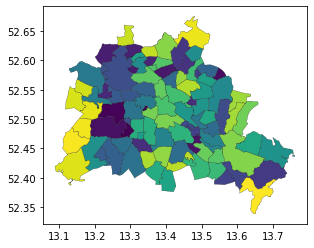

In [9]:
if show_plots: ortsteile.plot(cmap="viridis", edgecolor="black", linewidth=0.2)

### read in Planungsraueme shapefile

Number of zones:  448


,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry
broker Dow,,,,,,
10010311,Marzahn-Hellersdorf,Landsberger Tor,14.06.2006,1608201.44,10010311,"POLYGON ((13.58610 52.54937, 13.58536 52.54858..."


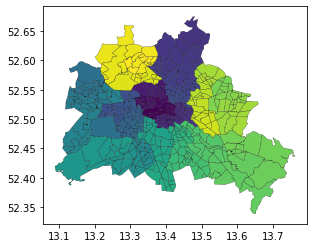

In [10]:
plr = gpd.read_file(input_path + "zone_shapes/lor_planungsraeume")

plr.to_crs(epsg=epsg, inplace=True)
if show_plots: plr.plot(cmap="viridis", edgecolor="black", linewidth=0.2)
# fix mistake from shapefile: 04030417 Schloßstraße (04 Charlottenburg-Wilmersdorf)
# is wrongly labeled as 06010102 Schloßstraße (06 Steglitz-Zehlendorf)
plr['broker Dow'][(plr['broker Dow']=='06010102') & (plr['BEZIRKSNAM']=='Charlottenburg-Wilmersdorf')] = '04030417'
plr.set_index(plr['broker Dow'], inplace=True)
print('Number of zones: ', len(plr))
plr.sample()

### set planungsraeume as reference zones

In [11]:
zones = plr.copy() if zone_ref == 'plr' else ortsteile if zone_ref == 'ortsteile' else None
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
hull_gs = GeoSeries([hull], crs=epsg)

### read in Umweltzone (SBahn Ring)

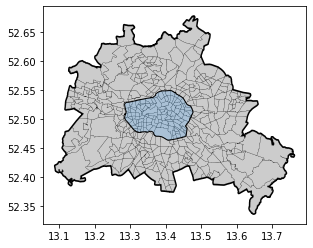

In [12]:
umweltzone = gpd.read_file(input_path + "zone_shapes/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=epsg)
umweltzone_geom = umweltzone['geometry'].iloc[0]
if show_plots: umweltzone.plot(color="#2299ff33", edgecolor="black", linewidth=1,
                               ax=zones.plot(color="#cccccc", edgecolor="black", linewidth=0.2, 
                                             ax=hull_gs.plot(color="None", edgecolor="black", linewidth=2)))

### read and clean in building block shapefile

In [13]:
# Add building block shapefile
blocks = gpd.read_file(input_path + "zone_shapes/Einwohnerdichte_2021.shp")
blocks.to_crs(epsg=epsg, inplace=True)
# remove blocks without geometry property
print("removing", sum(blocks.geometry == None), 
      "blocks with",
      round(sum(blocks[blocks.geometry == None]["ew2021"])),
      "inhabitants due to lack of geometry, e.g. block with schl5 =",
     blocks[blocks.geometry == None].iloc[0]["schl5"] if len(blocks[blocks.geometry == None])>0 else '')
blocks = blocks[blocks.geometry != None]
blocks = blocks[blocks['ew2021'] > 0]
blocks["zone"] = None

# add information whether block in umweltzone or not
blocks['umweltzone'] = [x.intersects(umweltzone['geometry'].iloc[0]) for x in blocks['geometry']]

removing 0 blocks with 0 inhabitants due to lack of geometry, e.g. block with schl5 = 


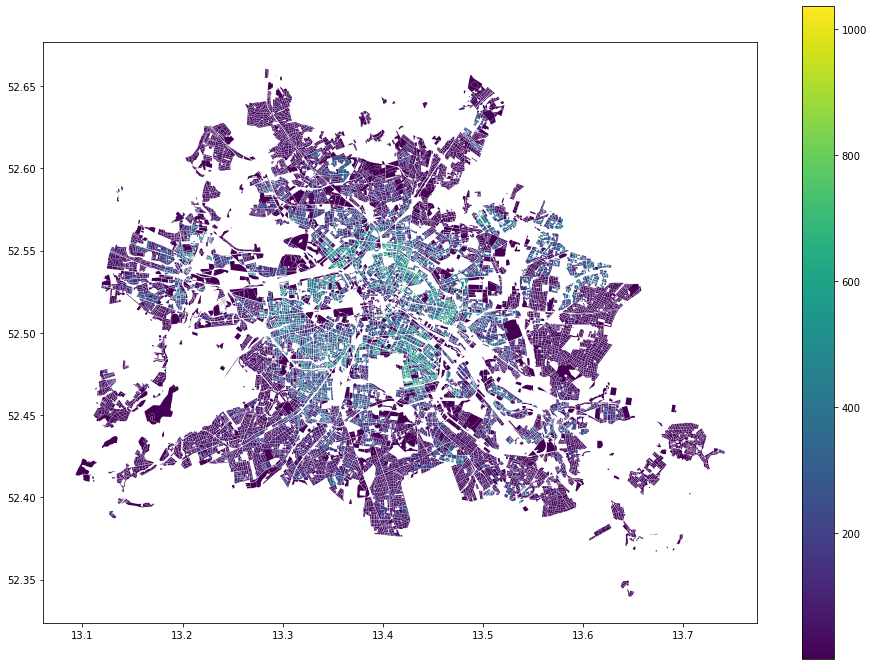

In [14]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "viridis", legend=True)
    plt.savefig(output_path+'plots/zones_blocks.png', dpi=300)

### assign a zone to each block (no longer necessary as zones originate from building block cluster assignment)

In [15]:
# assign zone to each block
blocks["zone"] = \
    blocks['geometry']\
        .apply(lambda g: zones.index[zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

# zones that haven't been matched to a building
zones[[i not in list(blocks["zone"]) for i in zones.index]]

,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry
broker Dow,,,,,,
04020314,Charlottenburg-Wilmersdorf,Messegelände,14.06.2006,897271.03,04020314,"POLYGON ((13.26230 52.50720, 13.26254 52.50737..."


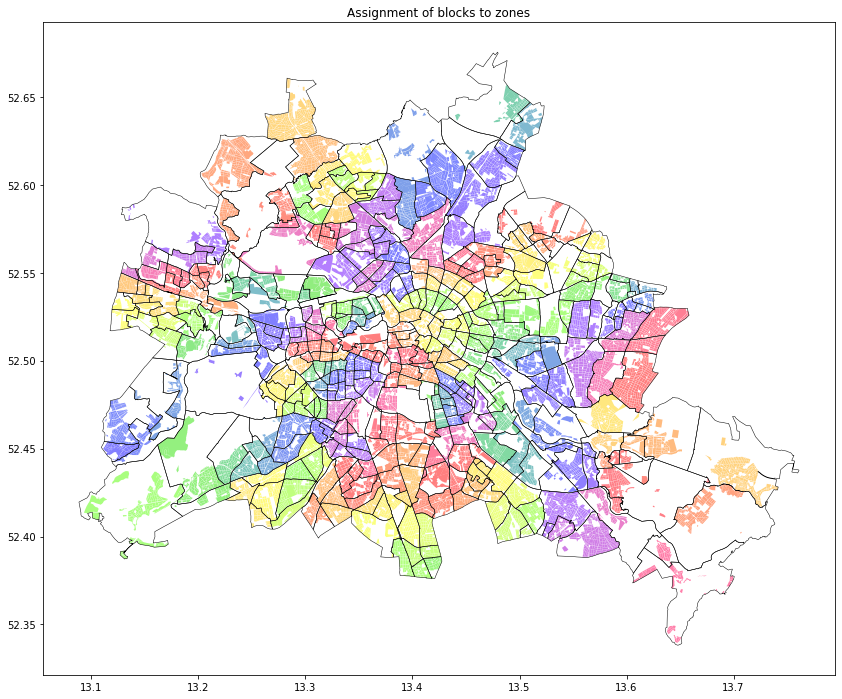

In [16]:
if show_plots:
    # plot
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='zone', cmap = "prism", alpha=.5)
    zones.plot(ax=ax, color="None", edgecolor="black", linewidth=0.5)
    ax.set_title("Assignment of blocks to zones")

### prepare clustering of building blocks to zones using k_means algorithm
(not implemented)

# Initialize stepmodel with zones

In [17]:
# Create the model with Coordinate Reference System epsg
sm = stepmodel.StepModel(epsg=epsg, coordinates_unit='degree')
# Save zones into the model
sm.zones = zones

## for each zone: sum up population from blocks and create centroids weighted by population

In [18]:
print(blocks['ew2021'].max(), blocks['ew2021'].mean(), blocks['ew2021'].min())

5653.0 251.53097934710192 3.0


popCentroid (13.212858019592474, 52.564534542419885) not within polygon for zone 05010101 ['Hakenfelde Nord']
popCentroid (13.166370493106127, 52.531250445739026) not within polygon for zone 05020417 ['Staakener Straße']
popCentroid (13.63734046068387, 52.371798928625005) not within polygon for zone 09031202 ['Schmöckwitz/Rauchfangswerder']
popCentroid (13.228214302480403, 52.580579171861594) not within polygon for zone 12224229 ['Konradshöhe/Tegelort']


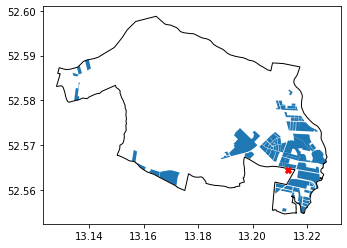

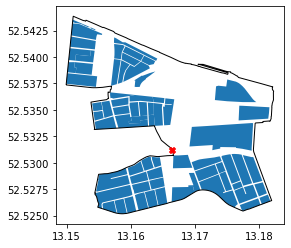

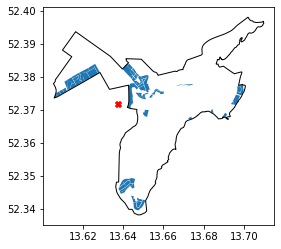

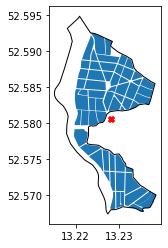

In [19]:
# t0=time.time()
# sum up population from blocks to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0.0,0.0)
sm.zones["popCentroidOffset"] = LineString([Point(0.0,0.0), Point(0.0,0.0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    geom_centroid = zone["geometry"].centroid
    blocksInZone = blocks[blocks["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2021 = sum(blocksInZone["ew2021"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2021
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for blockIndex, block in blocksInZone.iterrows():
        weigthedCoords["lon"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.x
        weigthedCoords["lat"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    if len(blocksInZone) == 0:
        popCentroid = geom_centroid
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone",
              zoneIndex, list(zone[[x for x in ['PLANUNGSRA', "nam"] if x in zone.keys()]]))
        if len(blocksInZone) > 0:
            GeoSeries(popCentroid, crs=sm.epsg).plot(
                ax=GeoSeries(zone['geometry'], crs=sm.epsg).plot(
                    ax=blocksInZone.plot(), color="None", edgecolor='black'),
                marker="X", color="red")
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([geom_centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

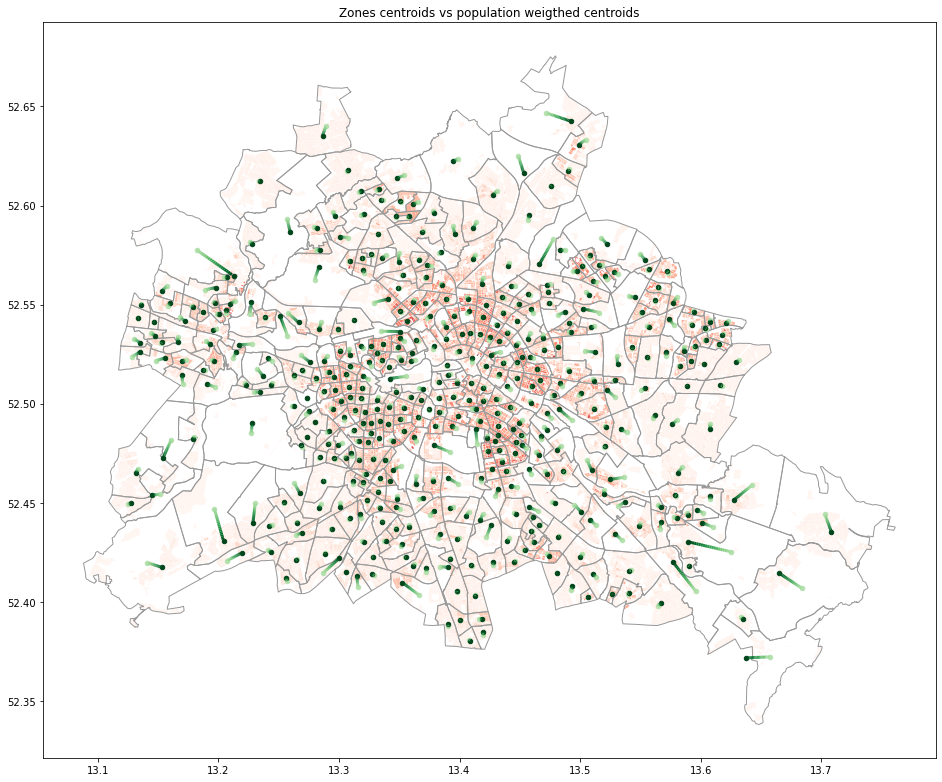

In [20]:
if show_plots:
    # show zones and popCentroids and their offsets from real geometrical centroids
    fig, ax = plt.subplots(1, 1, figsize=(16,16))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "Reds")
    # add zone borders and a bit of opacity
    sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
    nSteps = 20
    cbuff = 10
    cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
    gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
    for i in range(1,nSteps):
        l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.popCentroidOffset]
        gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
    gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
    ax.set_title("Zones centroids vs population weigthed centroids")
    plt.savefig(output_path+'plots/centroids_geo_vs_pop'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/centroids_geo_vs_pop'+'_dpi600.png', dpi=600)

# Add zone statistics weighted by population or block square meters


## Add employment data (based on data for planungsraeume and bezirke)

In [22]:
blocks.sample(2)

,schl5,ew2021,flalle,ew_ha_2021,typklar,geometry,zone,umweltzone
12304,1400761341000000,588.0,13131.937402,447.76,"Dichte Blockbebauung, geschlossener Hinterhof ...","POLYGON ((13.44134 52.47919, 13.44267 52.48023...",08010404,True
18728,1801550621000000,63.0,21404.724436,29.43,Freistehende Einfamilienhäuser mit Gärten,"POLYGON ((13.44850 52.56981, 13.44934 52.57035...",03030715,False


In [23]:
# read in employment data and create best guess for each plr employment
# only number of Niederlassungen per plr per Beschäftiungsgrößenklassen is given
employment = pd.read_excel(input_path + 'zone_stats/unternehmen_plr.xlsx')

plr['Bezirk'] = [employment['Bezirk'][employment['broker Dow'] == int(p)].iloc[0] for p in plr['broker Dow']]

# create guess for total employment per plr: 2/3 lower bound + 1/3 upper bound
employment['guess'] = \
    employment['0 bis unter 10'] * (0*80+10*20)/100 + \
    employment['10 bis unter 50'] * (10*60+50*40)/100 + \
    employment['50 bis unter 250'] * (50*60+250*40)/100 + \
    employment['250 und mehr'] * (250*60+300*40)/100
print('0 bis unter 10:', (0*80+10*20)/100, '10 bis unter 50:', (10*60+50*40)/100, '50 bis unter 250:', (50*60+250*40)/100, '250 und mehr:',(250*60+300*40)/100)
# create bezirke gdf based on information of employment data
bezirke = gpd.GeoDataFrame(
    {'Bezirk': employment['Bezirk'].unique()}, 
    geometry=[unary_union([x.buffer(0.0001) for x in plr['geometry'][plr['Bezirk']==b]]) for b in plr['Bezirk'].unique()], 
    crs=sm.epsg
    )
bezirke['guess_sum'] = [sum(employment['guess'][employment['Bezirk']==b]) for b in bezirke['Bezirk']]
bezirke['real_employment'] = [employment['Beschaeftige Bezirk'][employment['Bezirk']==b].iloc[0] for b in bezirke['Bezirk']]
bezirke['correction_factor'] = bezirke['real_employment'] / bezirke['guess_sum']
print('correction_factor', [round(x,2) for x in bezirke['correction_factor']], sum([round(x,2) for x in bezirke['correction_factor']])/len(bezirke))

# apply correction factor to guess
employment['corrected_guess'] = employment.apply(lambda row: (row['guess'] * bezirke['correction_factor'][bezirke['Bezirk'] == row['Bezirk']]).iloc[0], axis=1)
# employment = gpd.GeoDataFrame(employment, geometry=

0 bis unter 10: 2.0 10 bis unter 50: 26.0 50 bis unter 250: 130.0 250 und mehr: 270.0
correction_factor [1.27, 1.02, 0.94, 0.94, 1.16, 0.99, 0.99, 0.86, 0.97, 0.98, 0.96, 1.04] 1.01


In [24]:
# assign zone to each blocksum
blocks["plr"] = \
    blocks['geometry']\
        .apply(lambda g: plr.index[plr.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

blocks['area_calc'] = [x.area for x in blocks['geometry']]

# sum total are of blocks within plr
plr['block_area_calc'] = [sum(blocks['area_calc'][blocks['plr']==i]) for i in plr.index]

# calculate share of each block area in plr area 
blocks['plr_share'] = [a/plr['block_area_calc'][plr.index==p][0] if not p==None else 0 for p,a in zip(blocks['plr'], blocks['area_calc'])]
print("should be all around 1.00:", 
    min([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index if i in list(blocks['plr'])]), 
    max([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]))
print("plr not included:", [x for x in plr.index if x not in list(blocks['plr'])])

should be all around 1.00: 0.999999999999999 1.0000000000000007
plr not included: ['04020314']


In [25]:
# now obtain employment guess for each block 
blocks['plr_employment'] = [employment['corrected_guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment'] = blocks['plr_employment'] * blocks['plr_share']
blocks['plr_employment_guess'] = [employment['guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment_guess'] = blocks['plr_employment_guess'] * blocks['plr_share']
# now sum data from building block level to zone level
sm.zones['emp'] = [sum(blocks['employment'][blocks['zone']==i]) for i in sm.zones.index]
sm.zones['emp_guess'] = [sum(blocks['employment_guess'][blocks['zone']==i]) for i in sm.zones.index]

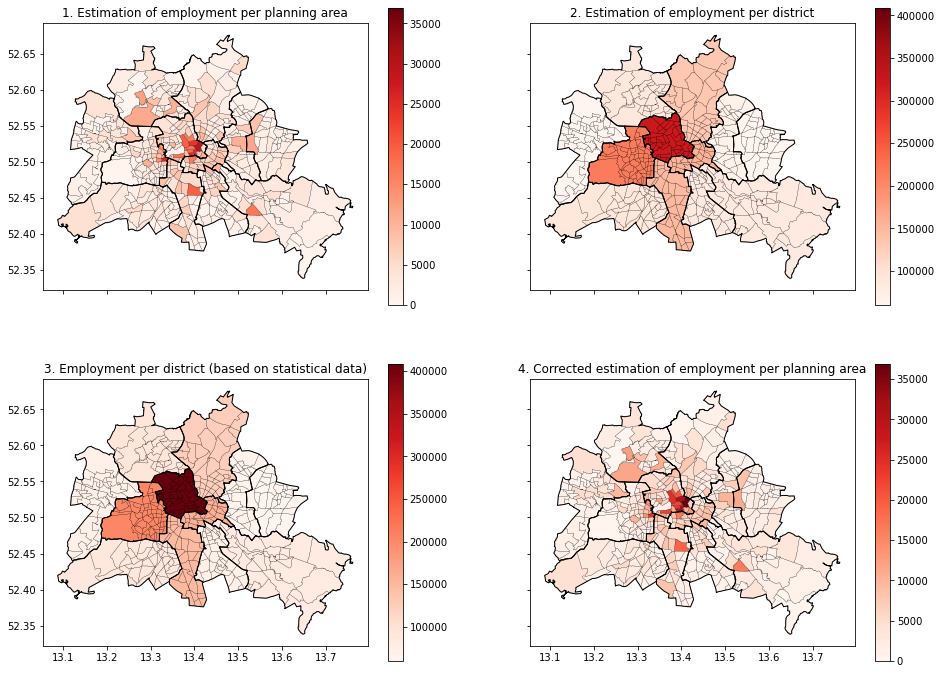

In [26]:
if show_plots:
    # this plot should be adapted to show the process. it could show the following:
    # employment data by district (Bezirk)
    # guess based on companies for plr
    # corrected guess for plr
    # employment per building 
    # employment per zone
    
    fig, ax = plt.subplots(2, 2, figsize=(16,12), sharex='all', sharey='all')
    
    vmin, vmax = min(sm.zones['emp_guess'].min(), sm.zones['emp'].min()), max(sm.zones['emp_guess'].max(), sm.zones['emp'].max())    
    vmin_bez, vmax_bez = min(bezirke['guess_sum'].min(), bezirke['real_employment'].min()), max(bezirke['guess_sum'].max(), bezirke['real_employment'].max())
    
    sm.zones.plot(ax=ax.flat[0], column='emp_guess', cmap = "Reds", legend= True, vmin = vmin, vmax=vmax)
    bezirke.plot(ax=ax.flat[1], column='guess_sum', cmap = "Reds", legend= True, vmin = vmin_bez, vmax=vmax_bez)
    bezirke.plot(ax=ax.flat[2], column='real_employment', cmap = "Reds", legend= True, vmin = vmin_bez, vmax=vmax_bez)
    sm.zones.plot(ax=ax.flat[3], column='emp', cmap = "Reds", legend= True, vmin = vmin, vmax=vmax)

    plr.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=0.15)
    
    bezirke.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=1)

    
    ax.flat[0].set_title("1. Estimation of employment per planning area") #based on employer size categories
    ax.flat[1].set_title("2. Estimation of employment per district") #based on employer size categories
    ax.flat[2].set_title("3. Employment per district (based on statistical data)")
    ax.flat[3].set_title("4. Corrected estimation of employment per planning area")

    plt.savefig(output_path+'plots/zones_employment.png', dpi=300)

## Car ownership

In [ ]:
## DATA ABOUT CAR OWNERSHIP WITHIN EACH ZONE IF POSSIBLE
'''
Private cars per LOR (PLR = 449)
In Berlin angemeldete Fahrzeuge (ohne Außerbetriebsetzungen und ohne Anhänger) nach Planungsräumen
Datei: /input/zone_stats/car_ownership_perPLR2019.xlsx

''' 
CarOwnership2019 = pd.read_excel(input_path + 'zone_stats/car_ownership_perPLR2019.xlsx', index_col = 0)
# filter private cars per PLR
CarOwnership2019 = CarOwnership2019.rename(columns={CarOwnership2019.columns[4]: 'privateCars'})
privateCarOwnership2019 = pd.DataFrame(CarOwnership2019.iloc[:, 4])
privateCarOwnership2019 = privateCarOwnership2019.iloc[1:]

In [ ]:
sm.zones['privateCarOwnership'] = privateCarOwnership2019

# Save zones

In [28]:
sm.zones.sample()

,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry,pop,popCentroid,popCentroidOffset,popCentroidLat,popCentroidLon,emp,emp_guess
broker Dow,,,,,,,,,,,,,
06040804,Steglitz-Zehlendorf,Krumme Lanke,14.06.2006,6416118.1,06040804,"POLYGON ((13.22446 52.42949, 13.22401 52.42982...",7413,POINT (13.228727677713877 52.43996276263098),LINESTRING (13.230693825864927 52.449776171569...,52.439963,13.228728,2572.853105,2594.0


In [29]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones.drop(columns=['emp_guess', 'DATUM_GUEL', 'popCentroid', 'popCentroidOffset', 'broker Dow'],
              errors='ignore', inplace=True)

In [30]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 20.57it/s]
